In [18]:
import torch
import torch.nn as nn
import sinabs.layers as sl
from tqdm.notebook import tqdm

from tonic.datasets.nmnist import NMNIST
from tonic.transforms import ToFrame
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

from sinabs.activation.surrogate_gradient_fn import PeriodicExponential

import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.manual_seed(0)

## Loading Data

In [3]:
batch_size = 64
num_workers = 4
epochs = 5
lr = 1e-3

In [4]:
root_dir = "./NMNIST"
_ = NMNIST(save_to=root_dir, train=True)
_ = NMNIST(save_to=root_dir, train=False)

In [5]:
n_time_steps = 50
to_raster = ToFrame(sensor_size=NMNIST.sensor_size, n_time_bins=n_time_steps)

snn_train_dataset = NMNIST(save_to=root_dir, train=True, transform=to_raster)
snn_test_dataset = NMNIST(save_to=root_dir, train=False, transform=to_raster)

In [6]:
snn_train_dataloader = DataLoader(snn_train_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=True)
snn_test_dataloader = DataLoader(snn_test_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=False)

## Network Module

We need to define a `nn.Module` implementing the network we want the chip to reproduce.

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('device: ', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')

device:  NVIDIA RTX A4000


In [8]:
class SNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(2, 10, 2, 1, bias=False)
        self.iaf1 = sl.IAFSqueeze(batch_size=batch_size, min_v_mem=-1.0, surrogate_grad_fn=PeriodicExponential())
        self.pool1 = nn.AvgPool2d(2,2)
        self.pool1a = nn.AvgPool2d(6,6)

        self.conv2 = nn.Conv2d(10, 10, 2, 1, bias=False)
        self.iaf2 = sl.IAFSqueeze(batch_size=batch_size, min_v_mem=-1.0, surrogate_grad_fn=PeriodicExponential())
        self.pool2 = nn.AvgPool2d(3,3)

        self.conv3 = nn.Conv2d(10, 10, 3, 1, bias=False)
        self.iaf3 = sl.IAFSqueeze(batch_size=batch_size, min_v_mem=-1.0, surrogate_grad_fn=PeriodicExponential())
        self.pool3 = nn.AvgPool2d(2,2)

        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(10, 10, bias=False)
        self.iaf4 = sl.IAFSqueeze(batch_size=batch_size, min_v_mem=-1.0, surrogate_grad_fn=PeriodicExponential())

        self.merge = sl.Merge()


    def detach_neuron_states(self):
        for name, layer in self.named_modules():
            if name != '':
                if isinstance(layer, sl.StatefulLayer):
                    for name, buffer in layer.named_buffers():
                        buffer.detach_()

    def init_weights(self):
        for name, layer in self.named_modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight.data)

    def forward(self, x):
        
        con1_out = self.conv1(x)
        iaf1_out = self.iaf1(con1_out)
        pool1_out = self.pool1(iaf1_out)
        pool1a_out = self.pool1a(iaf1_out)

        conv2_out = self.conv2(pool1_out)
        iaf2_out = self.iaf2(conv2_out)
        pool2_out = self.pool2(iaf2_out)

        merged = self.merge(pool1a_out, pool2_out)

        conv3_out = self.conv3(merged)
        iaf3_out = self.iaf3(conv3_out)
        pool3_out = self.pool3(iaf3_out)

        flat_out = self.flat(pool3_out)
        
        fc1_out = self.fc1(flat_out)
        iaf4_out = self.iaf4(fc1_out)

        return iaf4_out

In [9]:
snn = SNN().to(device)

In [10]:
# x = torch.randn((batch_size, 2, 34, 34)).to(device)

# con1_out = snn.conv1(x)
# iaf1_out = snn.iaf1(con1_out)
# pool1_out = snn.pool1(iaf1_out)
# pool1a_out = snn.pool1a(iaf1_out)
# print(pool1a_out.shape)

# conv2_out = snn.conv2(pool1_out)
# iaf2_out = snn.iaf2(conv2_out)
# pool2_out = snn.pool2(iaf2_out)
# print(pool2_out.shape)

# conv3_out = snn.conv3(pool2_out)
# iaf3_out = snn.iaf3(conv3_out)
# pool3_out = snn.pool3(iaf3_out)

# flat_out = snn.flat(pool3_out)
# print(flat_out.shape)

# fc1_out = snn.fc1(flat_out)
# iaf4_out = snn.iaf4(fc1_out)

In [11]:
snn.init_weights()

In [12]:
optimizer = Adam(snn.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)
loss_fn = CrossEntropyLoss()

## Define train and test

In [13]:
def train(dataloader, model, loss_fn, optimizer, epochs, test_func, dataloader_test):
    epochs_y = []
    epochs_x = []
    epochs_acc = []
    model.train()

    for e in range(epochs):
        losses = []
        batches = []
        batch_count = 0
        train_p_bar = tqdm(snn_train_dataloader)

        for X, y in train_p_bar:
            # reshape the input from [Batch, Time, Channel, Height, Width] into [Batch*Time, Channel, Height, Width]
            X = X.reshape(-1, 2, 34, 34).to(dtype=torch.float, device=device)
            y = y.to(dtype=torch.long, device=device)

            # forward
            pred = model(X)

            # reshape the output from [Batch*Time,num_classes] into [Batch, Time, num_classes]
            pred = pred.reshape(batch_size, n_time_steps, -1)

            # accumulate all time-steps output for final prediction
            pred = pred.sum(dim = 1)
            loss = loss_fn(pred, y)

            # gradient update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # detach the neuron states and activations from current computation graph(necessary)
            model.detach_neuron_states()

            train_p_bar.set_description(f"Epoch {e} - BPTT Training Loss: {round(loss.item(), 4)}")

            batch_count += 1
            losses.append(loss.item())
            batches.append(batch_count)

        epochs_y.append(losses)
        epochs_x.append(batches)

        acc = test_func(dataloader_test, model)
        print(f'Epoch {e} accuracy: {acc}')
        epochs_acc.append(acc)

    return epochs_x, epochs_y, epochs_acc


In [14]:
def test(dataloader, model):
    correct_predictions = []
    with torch.no_grad():
        test_p_bar = tqdm(dataloader)
        for X, y in test_p_bar:
            # reshape the input from [Batch, Time, Channel, Height, Width] into [Batch*Time, Channel, Height, Width]
            X = X.reshape(-1, 2, 34, 34).to(dtype=torch.float, device=device)
            y = y.to(dtype=torch.long, device=device)

            # forward
            output = model(X)

            # reshape the output from [Batch*Time,num_classes] into [Batch, Time, num_classes]
            output = output.reshape(batch_size, n_time_steps, -1)

            # accumulate all time-steps output for final prediction
            output = output.sum(dim=1)

            # calculate accuracy
            pred = output.argmax(dim=1, keepdim=True)

            # compute the total correct predictions
            correct_predictions.append(pred.eq(y.view_as(pred)))

            test_p_bar.set_description(f"Testing Model...")
    
    correct_predictions = torch.cat(correct_predictions)
    return correct_predictions.sum().item()/(len(correct_predictions))*100

## Training loop (HPO)

In [15]:
epochs_x, epochs_y, epochs_acc = train(snn_train_dataloader, snn, loss_fn, optimizer, epochs, test, snn_test_dataloader)

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 0 accuracy: 76.81290064102564


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 1 accuracy: 85.34655448717949


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 2 accuracy: 87.04927884615384


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 3 accuracy: 89.90384615384616


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 4 accuracy: 92.1073717948718


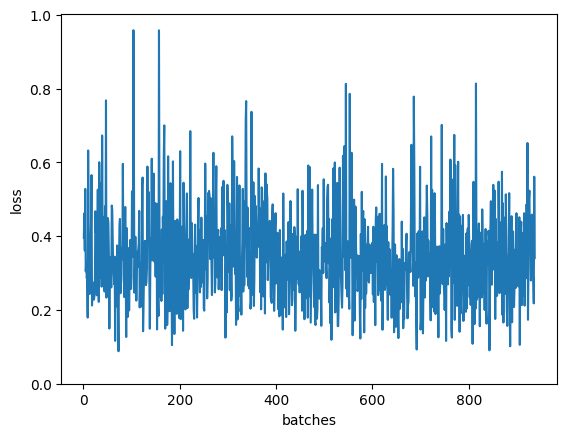

In [16]:
plt.plot(epochs_x[-1], epochs_y[-1])
plt.xlabel('batches')
plt.ylabel('loss')
plt.ylim(0,)
plt.show()

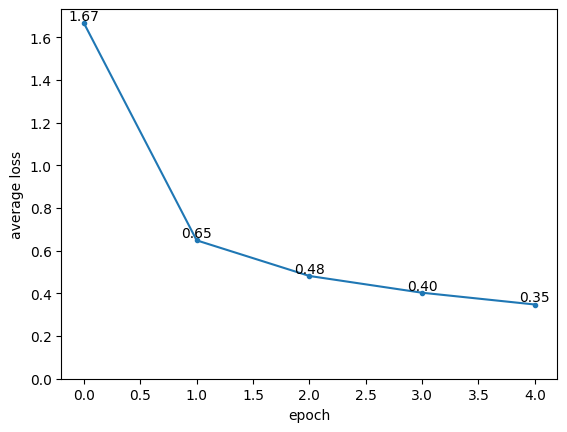

In [19]:
y_avg = []
for y in epochs_y:
    y_avg.append(np.mean(y))

plt.plot(np.arange(len(epochs_x)), y_avg, marker = '.')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.ylim(0,)
for i, txt in enumerate(y_avg):
    plt.text(i, txt, f'{txt:.2f}', ha='center', va='bottom')
plt.show()

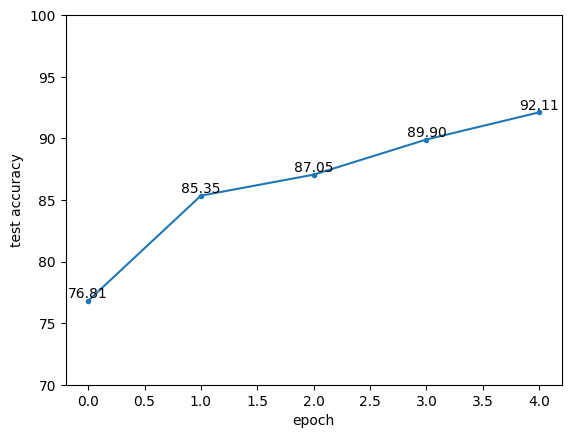

In [21]:
plt.plot(np.arange(len(epochs_x)), epochs_acc, marker = '.')
plt.xlabel('epoch')
plt.ylabel('test accuracy')
plt.ylim(70, 100)
for i, txt in enumerate(epochs_acc):
    plt.text(i, txt, f'{txt:.2f}', ha='center', va='bottom')
plt.show()